In [15]:
# Data Generation
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
lr = 0.001
n_samples = 1000
X = np.random.randn(n_samples,2)
noiseless_lables= (np.sin([X[:,0]])+ 0.5 *X[:,1]**2+ 0.3*X[:,0]*X[:,1]>0.5).astype(int)
noise  = np.random.randn(n_samples)*(0.1+0.3*X[:,1]**2)
noisy_lables = noiseless_lables+ noise
y = (noisy_lables>0.5)
y = y.astype(int)
print("total samples  " , n_samples, "number of 1s  ", np.sum(y==1))

total samples   1000 number of 1s   416


In [16]:
# Getting samples ready for training the N.N
y = y.reshape(-1)
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)  # 60% train, 40% temp
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)  # 20% validation, 20% test

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [17]:
# Training a model with Heteroskedastic loss function without changing delta
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class HeteroskedasticNN(nn.Module):
      def __init__(self, input_len):
          super(HeteroskedasticNN, self).__init__()
          self.fc1 = nn.Linear(input_len,64)
          self.fc2=nn.Linear(64,64)
          self.mean = nn.Linear(64,1)
          self.log_var = nn.Linear(64,1)
      def forward(self, x):
        x = torch.relu(self.fc1(x))
        x= torch.relu(self.fc2(x))
        mean_pred = self.mean(x)
        log_var_pred = self.log_var(x)
        return mean_pred, log_var_pred

# loss for each sample is:
def heteroskedastic_loss(y_true, y_pred_mean, y_pred_log_var):
      # print("hey", y_true)
      var = torch.exp(y_pred_log_var) # e^log(var)= var!
      loss = 0.5* torch.log(var) + 0.5* ((y_true - y_pred_mean)**2)/var
      return loss.mean()

model = HeteroskedasticNN(input_len=2)
optimizer = optim.Adam(model.parameters(), lr =0.001)



# training loop

num_epochs = 100
for epoch in range(num_epochs):
      model.train()
      mean_pred, log_var_pred = model(x_train_tensor)
      loss = heteroskedastic_loss(y_train_tensor, mean_pred,log_var_pred)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

model.eval()
with torch.no_grad():
    mean_pred_ , log_var_pred_ = model(x_test_tensor)
    test_loss = heteroskedastic_loss(y_test_tensor, mean_pred_, log_var_pred_)
    print("Test loss is :   ", test_loss)
    y_pred_binary = (mean_pred_ > 0.5).float()
    accuracy_without_delta = accuracy_score(y_test_tensor, y_pred_binary)
    print("Accuracy is :   ", accuracy_without_delta)

    precision_without_delta = precision_score(y_test_tensor, y_pred_binary)
    print("precision_score is :   ", precision_without_delta)

    recall_without_delta = recall_score(y_test_tensor, y_pred_binary)
    print("recall_score is :   ", recall_without_delta)

    f1_without_delta = f1_score(y_test_tensor, y_pred_binary)
    print("f1_score is :   ", f1_without_delta)
    total_variance_without_delta = log_var_pred_.tolist()
    errors = np.abs(y_test_tensor - y_pred_binary)
    error_threshold = 0.5
    wrong_predictions = errors > error_threshold
    correct_predictions = errors <= error_threshold
    avg_variance_wrong = np.mean(np.exp(np.array(log_var_pred_[wrong_predictions])))
    avg_variance_correct = np.mean(np.exp(np.array(log_var_pred_[correct_predictions])))

    print("Average variance for wrong predictions:", avg_variance_wrong)
    print("Average variance for correct predictions:", avg_variance_correct)




Test loss is :    tensor(-0.6174)
Accuracy is :    0.845
precision_score is :    0.7349397590361446
recall_score is :    0.8714285714285714
f1_score is :    0.7973856209150327
Average variance for wrong predictions: 0.099518076
Average variance for correct predictions: 0.092167765


In [18]:
# Training a model with Heteroskedastic loss function with changing delta
from sklearn.metrics import matthews_corrcoef

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class HeteroskedasticNN(nn.Module):
      def __init__(self, input_len):
          super(HeteroskedasticNN, self).__init__()
          self.fc1 = nn.Linear(input_len,64)
          self.fc2=nn.Linear(64,64)
          self.mean = nn.Linear(64,1)
          self.log_var = nn.Linear(64,1)
      def forward(self, x):
        x = torch.relu(self.fc1(x))
        x= torch.relu(self.fc2(x))
        mean_pred = self.mean(x)
        log_var_pred = self.log_var(x)
        return mean_pred, log_var_pred
# loss for each sample is:
def heteroskedastic_loss_with_delta(y_true, y_pred_mean, y_pred_log_var, delta):
      # print("hey", y_true)
      var = torch.exp(y_pred_log_var) # e^log(var)= var!

      loss = delta* 0.5* torch.log(var) + 0.5* ((y_true - y_pred_mean)**2)/var
      return loss.mean()
deltas =  [0.001, 0.003, 0.01, 0.1, 0.5, 1.0, 1.5  ,2.0, 2.5,3.5, 5.0]
best_mcc = -1
best_delta = -10
best_accuracy = -1
best_f1=-1
best_recall_data = -1
best_precision = -1
total_variance_delta=[]

for delta in deltas:
    model = HeteroskedasticNN(input_len=2)
    optimizer = optim.Adam(model.parameters(), lr =0.001)



    # training loop

    num_epochs = 100
    for epoch in range(num_epochs):

          model.train()
          mean_pred, log_var_pred = model(x_train_tensor)
          # if epoch ==30:
                  # total_variance_delta.extend(log_var_pred.tolist())

          loss = heteroskedastic_loss_with_delta(y_train_tensor, mean_pred,log_var_pred,delta)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
    model.eval()
    with torch.no_grad():
        mean_pred_ , log_var_pred_ = model(x_test_tensor)
        print("delta is :", delta)
        test_loss = heteroskedastic_loss_with_delta(y_test_tensor, mean_pred_, log_var_pred_,delta)
        print("Test loss is :   ", test_loss)
        y_pred_binary = (mean_pred_ > 0.5).float()
        accuracy_delta = accuracy_score(y_test_tensor, y_pred_binary)
        print("Accuracy is :   ", accuracy_delta)

        precision_delta = precision_score(y_test_tensor, y_pred_binary)
        print("precision_score is :   ", precision_delta)

        recall_delta = recall_score(y_test_tensor, y_pred_binary)
        print("recall_score is :   ", recall_delta)

        f1_delta = f1_score(y_test_tensor, y_pred_binary)
        print("f1_score is :   ", f1_delta)
        mcc = matthews_corrcoef(y_test_tensor.numpy(), y_pred_binary.numpy())
        print("mcc is ", mcc)
        if best_mcc< mcc :

            best_mcc = mcc
            best_delta = delta
            best_accuracy = accuracy_delta
            best_f1=f1_delta
            best_recall_data = recall_delta
            best_precision = precision_delta
            total_variance_delta = log_var_pred.tolist()
        errors = np.abs(y_test_tensor - y_pred_binary)
        error_threshold = 0.5
        wrong_predictions = errors > error_threshold
        correct_predictions = errors <= error_threshold
        avg_variance_wrong = np.mean(np.exp(np.array(log_var_pred_[wrong_predictions])))
        avg_variance_correct = np.mean(np.exp(np.array(log_var_pred_[correct_predictions])))

        print("Average variance for wrong predictions:", avg_variance_wrong)
        print("Average variance for correct predictions:", avg_variance_correct)





print("best delta found" , best_delta)
print("Accuracy is :   ", best_accuracy)
print("precision_score is :   ", best_precision)

print("Test loss is :   ", test_loss)
print("f1_score is :   ", best_f1)
print("mcc is ", best_mcc)

model.eval()
with torch.no_grad():
        print(" The Test set :")
        mean_pred_ , log_var_pred_ = model(x_val_tensor)
        # print("delta is :", delta)
        test_loss = heteroskedastic_loss_with_delta(y_val_tensor, mean_pred_, log_var_pred_,best_delta)
        print("Test loss is :   ", test_loss)
        y_pred_binary = (mean_pred_ > 0.5).float()
        accuracy_delta = accuracy_score(y_val_tensor, y_pred_binary)
        print("Accuracy is :   ", accuracy_delta)

        precision_delta = precision_score(y_val_tensor, y_pred_binary)
        print("precision_score is :   ", precision_delta)

        recall_delta = recall_score(y_val_tensor, y_pred_binary)
        print("recall_score is :   ", recall_delta)

        f1_delta = f1_score(y_val_tensor, y_pred_binary)
        print("f1_score is :   ", f1_delta)
        mcc = matthews_corrcoef(y_val_tensor.numpy(), y_pred_binary.numpy())
        print("mcc is ", mcc)

        errors = np.abs(y_val_tensor - y_pred_binary)
        error_threshold = 0.5
        wrong_predictions = errors > error_threshold
        correct_predictions = errors <= error_threshold
        avg_variance_wrong = np.mean(np.exp(np.array(log_var_pred_[wrong_predictions])))
        avg_variance_correct = np.mean(np.exp(np.array(log_var_pred_[correct_predictions])))

        print("Average variance for wrong predictions:", avg_variance_wrong)
        print("Average variance for correct predictions:", avg_variance_correct)





delta is : 0.001
Test loss is :    tensor(0.0053)
Accuracy is :    0.84
precision_score is :    0.7714285714285715
recall_score is :    0.7714285714285715
f1_score is :    0.7714285714285715
mcc is  0.6483516483516484
Average variance for wrong predictions: 53.210804
Average variance for correct predictions: 20.38583
delta is : 0.003
Test loss is :    tensor(0.0087)
Accuracy is :    0.83
precision_score is :    0.7647058823529411
recall_score is :    0.7428571428571429
f1_score is :    0.7536231884057971
mcc is  0.6240465489981082
Average variance for wrong predictions: 19.138617
Average variance for correct predictions: 14.664472
delta is : 0.01
Test loss is :    tensor(0.0178)
Accuracy is :    0.84
precision_score is :    0.7714285714285715
recall_score is :    0.7714285714285715
f1_score is :    0.7714285714285715
mcc is  0.6483516483516484
Average variance for wrong predictions: 14.387826
Average variance for correct predictions: 7.214239
delta is : 0.1
Test loss is :    tensor(0.0

In [19]:
# Training a model with binary cross entropy loss function
# excluding the log(var) in the loss function
class StandarNN(nn.Module):
    def __init__(self,input_len):
        super(StandarNN, self).__init__()
        self.fc1 = nn.Linear(input_len,64)
        self.fc2=nn.Linear(64,64)
        self.output = nn.Linear(64, 1)
    def forward( self, x):
      x = torch.relu(self.fc1(x))
      x=  torch.relu(self.fc2(x))
      out = torch.sigmoid(self.output(x))  # Sth between 0,1 using 1/e^(-x)+1
      return out

standard_model = StandarNN(input_len =2)
optimizer = optim.Adam(standard_model.parameters(), lr= 0.001)
criterion = nn.BCELoss()
# training the model:
for epoch in range(num_epochs):
    standard_model.train()

    # Forward pass
    y_pred = standard_model(x_train_tensor)

    # Compute BCE loss
    loss = criterion(y_pred, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

standard_model.eval()
with torch.no_grad():
    mean_pred_ = standard_model(x_test_tensor)
    y_pred_binary = (mean_pred_ > 0.5).float()
    accuracy_standard = accuracy_score(y_test_tensor, y_pred_binary)
    print("Accuracy is :   ", accuracy_standard)

    precision_standard = precision_score(y_test_tensor, y_pred_binary)
    print("precision_score is :   ", precision_standard)

    recall_standard = recall_score(y_test_tensor, y_pred_binary)
    print("recall_score is :   ", recall_standard)

    f1_standard = f1_score(y_test_tensor, y_pred_binary)
    print("f1_score is :   ", f1_standard)

Accuracy is :    0.87
precision_score is :    0.775
recall_score is :    0.8857142857142857
f1_score is :    0.8266666666666667


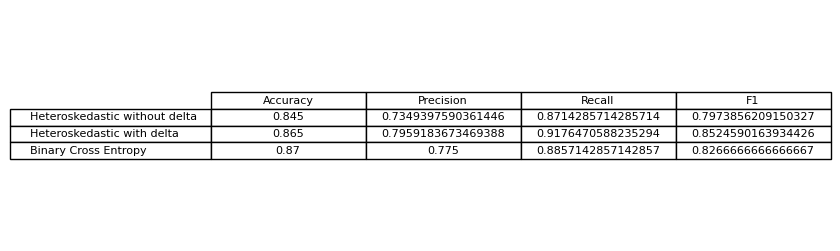

best delta is  0.5


In [20]:
# Comparing Results:
# Heterosdeskedastic without delta

import matplotlib.pyplot as plt
import pandas as pd

# Create the data for the table
data = {
    "Accuracy": [accuracy_without_delta, accuracy_delta, accuracy_standard],
    "Precision": [precision_without_delta, precision_delta, precision_standard],
    "Recall": [recall_without_delta, recall_delta, recall_standard],
    "F1": [f1_without_delta, f1_delta, f1_standard]
}

# Create a DataFrame
df = pd.DataFrame(data, index=[
    "Heteroskedastic without delta",
    "Heteroskedastic with delta",
    "Binary Cross Entropy"
])

# Plotting the table
fig, ax = plt.subplots(figsize=(8, 3))  # Set the figure size
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center')

# To show the table
plt.show()
print("best delta is ", best_delta)

